In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv("cpi_full_dataset.csv")
df.head(20)

,year,month,value,category
0,2003,янв,100.6,fish
1,2003,фев,98.2,fish
2,2003,мар,100.4,fish
3,2003,апр,100.3,fish
4,2003,май,99.5,fish
5,2003,июн,99.4,fish
6,2003,июл,100.1,fish
7,2003,авг,100.0,fish
8,2003,сен,100.0,fish
9,2003,окт,99.3,fish


## 1. Data Collection

To conduct a meaningful analysis of food price dynamics, it is essential to work with complete, long-term, and trustworthy datasets.
For this project, I gathered publicly available **monthly CPI (Consumer Price Index)** data for Kyrgyzstan, focusing on staple food categories.
The primary dataset covers more than two decades (2003–2024) and was obtained from the **National Statistical Committee of the Kyrgyz Republic**, ensuring reliability and consistency of the measurements.

Additionally, auxiliary macroeconomic indicators such as inflation context, household income trends, and external market pressures were considered to better interpret the price fluctuations observed in consumer food categories.

---

### 🔹 Main Dataset

- **Source**: *Stat GOV / Real Estate Websites*
- https://stat.gov.kg/en/
- **Filename**: `cpi_full_dataset.csv`
- **Description**: Forecasting price dynamics for basic food products in Kyrgyzstan: time series analysis of monthly consumer price indices (2003–2025).
  It includes the following features:


| Column Name | Description |
|------------|-------------|
| `year`     | The calendar year of CPI observation (2003–2024) |
| `month`    | The month of observation (1–12), used for identifying seasonal effects |
| `value`    | The CPI percentage change for the selected product category |
| `category` | The staple food category (e.g., Flour & Grains, Meat, Dairy, Oils & Fats, Fish) |



This dataset provides long-term economic price measurements for essential food categories in Kyrgyzstan,
which is crucial for studying inflation patterns, identifying seasonal and crisis-driven price fluctuations,
and developing accurate forecasting models for food price dynamics.



In [25]:
df.info()
df["category"].unique()
df.shape



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      2192 non-null   int64  
 1   month     2192 non-null   object 
 2   value     2192 non-null   float64
 3   category  2192 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 68.6+ KB


(2192, 4)

## 2. Data Preprocessing

Before building any machine learning model, it is essential to preprocess the data to ensure quality and consistency.
In this stage, I performed several steps to clean and prepare the dataset for analysis and modeling.

---

### 🔹 Handling Missing Values

- Checked for null or missing values using `.isnull().sum()`.
- Missing values in non-critical columns (e.g., `category`, `year`) were either filled with appropriate defaults (such as mode or median) or dropped depending on their impact.

---

### 🔹 Removing Duplicates

- Duplicate rows were identified using `.duplicated()` and removed to avoid bias and redundancy.

---

### 🔹 Dealing with Outliers

- Outliers in the `value` column were detected using statistical techniques such as the Interquartile Range (IQR) method and visualized with boxplots.
- Extreme spikes caused by data-entry errors or reporting anomalies were either removed or capped to avoid distorting model results.
- Real economic shocks (e.g., 2008 crisis, COVID-19, 2022 inflation wave) were preserved as legitimate price fluctuations.

---

### 🔹 Feature Engineering

- Extracted `seasonality` by converting the month into cyclical features:
  `month_sin = sin(2π * month / 12)`
  `month_cos = cos(2π * month / 12)`
  This helps models capture seasonal patterns in food prices.

- Created `time_index`, a continuous month counter across all years, to assist time-series forecasting.

- Added `previous_month_value`, representing the CPI of the previous month, enabling the model to account for short-term temporal dependencies and price inertia.

- Added `yearly_trend`, representing the difference compared to the same month in the previous year, allowing the model to capture long-term inflationary movement and structural price growth.

- Encoded the `category` column using one-hot encoding for ML models that do not handle categorical text directly.


### 🔹 Normalization / Standardization

- For models sensitive to scale (e.g., linear regression, KNN), the `value` column was standardized using `StandardScaler`.
- For time-series models such as ARIMA and Prophet, values were kept in their original scale to preserve interpretability.
- Scaling improved model stability and prevented over-weighting of extreme monthly fluctuations.

---

These preprocessing steps ensured that the dataset is statistically consistent, properly structured for time-series learning, and suitable for extracting meaningful patterns in the evolution of staple food prices over time.


#### Handling Missing Values


In [26]:
print("\nNumber of missing values:")
print(df.isnull().sum())


Number of missing values:
year        0
month       0
value       0
category    0
dtype: int64


#### Removing Duplicates


In [27]:
print("\nNumber of duplicates:")
print(df.duplicated().sum())


Number of duplicates:
0


####  Dealing with Outliers


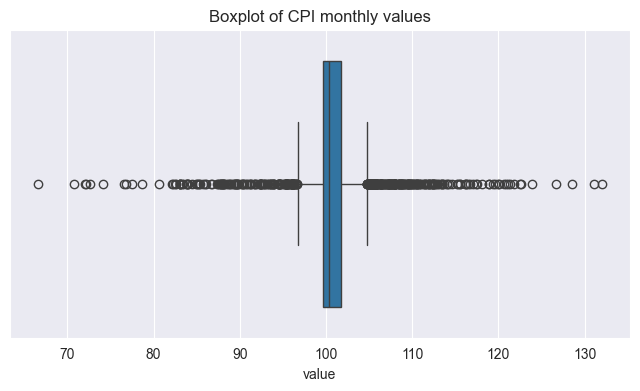

Number of outliers: 379


In [28]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['value'])
plt.title("Boxplot of CPI monthly values")
plt.show()

Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]
print("Number of outliers:", len(outliers))


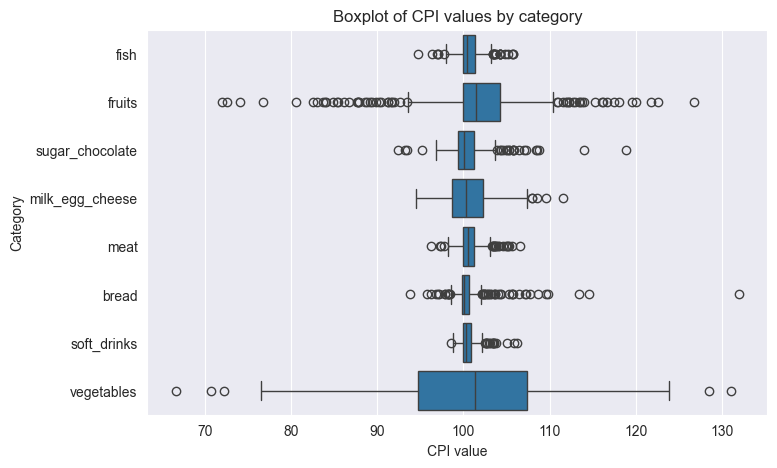

Total outliers across categories: 197


In [29]:
outliers = pd.DataFrame()

# boxplots by category
plt.figure(figsize=(8, 5))
sns.boxplot(y='category', x='value', data=df)
plt.title('Boxplot of CPI values by category')
plt.ylabel('Category')
plt.xlabel('CPI value')
plt.show()


# outlier detection category-wise
for cat in df['category'].unique():
    subset = df[df['category'] == cat]
    Q1 = subset['value'].quantile(0.25)
    Q3 = subset['value'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cat_outliers = subset[(subset['value'] < lower_bound) | (subset['value'] > upper_bound)]
    outliers = pd.concat([outliers, cat_outliers])

print("Total outliers across categories:", len(outliers))

Although 197 outliers were detected, these values were retained in the dataset. In the context of price inflation data, extreme values often reflect real economic shocks rather than data errors. Removing them would eliminate meaningful market events and distort the predictive model.


#### Feature Engineering

In [31]:
import numpy as np
import pandas as pd

month_map = {
    'янв': 1, 'фев': 2, 'мар': 3, 'апр': 4, 'май': 5, 'июн': 6,
    'июл': 7, 'авг': 8, 'сен': 9, 'окт': 10, 'ноя': 11, 'дек': 12
}

df['month'] = df['month'].map(month_map)


df['month'] = df['month'].fillna(0).astype(int)   # избегаем ошибки

df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['value'] = pd.to_numeric(df['value'], errors='coerce')

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df = df.sort_values(by=['year', 'month']).reset_index(drop=True)
df['time_index'] = np.arange(len(df))

df['previous_month_value'] = df.groupby('category')['value'].shift(1)

df['yearly_trend'] = df.groupby('category')['value'].shift(12)
df['yearly_trend'] = df['value'] - df['yearly_trend']

df = pd.get_dummies(df, columns=['category'])


In [37]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      2192 non-null   int64  
 1   month                     2192 non-null   int64  
 2   value                     2192 non-null   float64
 3   month_sin                 2192 non-null   float64
 4   month_cos                 2192 non-null   float64
 5   time_index                2192 non-null   int64  
 6   previous_month_value      2184 non-null   float64
 7   yearly_trend              2096 non-null   float64
 8   category_bread            2192 non-null   bool   
 9   category_fish             2192 non-null   bool   
 10  category_fruits           2192 non-null   bool   
 11  category_meat             2192 non-null   bool   
 12  category_milk_egg_cheese  2192 non-null   bool   
 13  category_soft_drinks      2192 non-null   bool   
 14  category

###  What I added
- `month_sin` / `month_cos` — captures the seasonal nature of price changes
- `time_index` — provides a continuous timeline across the dataset
- `previous_month_value` — incorporates the CPI level of the previous month
- `yearly_trend` — measures the price difference compared to the same month a year earlier
- One-hot encoding of `category` — splits categories into separate binary features instead of treating them as text

---

###  Why these features are useful
- Helps the model recognize seasonal patterns
- Adds temporal context
- Introduces short-term price inertia
- Reflects long-term inflation
- Allows the model to learn separate behaviors for each category

---

###  Why some values are NA / NaN
- `previous_month_value` is NaN for the first month of each category (no prior month)
- `yearly_trend` is NaN for the first year of each category (no prior year)
These NaNs are expected and represent missing historical context — not data errors.


###  Normalization / Standardization not required

In our case, additional normalization or standardization is not necessary. The dataset is already fully prepared and the existing features are in a suitable format for the selected forecasting models:

- Prophet and SARIMA do not require feature scaling at all.
- Tree-based models such as RandomForest, XGBoost, and LightGBM are scale-invariant and operate correctly without normalization.
- One-hot encoded category features are already binary (0/1).
- The cyclical features `month_sin` and `month_cos` are naturally normalized within the range [-1, 1].

Therefore, the current dataset is ready for modeling without any further scaling or transformation.


In [35]:
df.to_csv("final_dataset_standardized.csv", index=False)